## Weather-Prediction

Predicting rain or weather is a common problem in machine learning. Different machine learning algorithms can be used to model and predict rainfall. In this assignment, we are asked to complete the analysis to predict whether there will be rain tomorrow or not. In particular, we are required to apply the tools of machine learning to visualize and predict the possibility of rainfall in Australia. 

We must make use of various Machine Learning Algorithms like **Decision Trees, Logistic Regression, Gradient Boosted Machines and Random Forest** to predict whether it will rain tomorrow or not. We shall make use of the various **functions and libraries** within pyspark itself.

# Step 1 - Import Spark Session and Initialize Spark

Let's begin with loading all the necessary modules in the system.

- **SparkContext** and **SparkConf** from **pyspark** to create a **Spark Instance**

- **SparkSession** from **pyspark.sql** to work with the **SparkSession**

- **IntegerType and DoubleType** from **pyspark.sql.types** to convert datatypes

- **mean, stddev, col and when** from **pyspark.sql.functions** for stats

- **mode** from **statistics** to calculate the mode

- **StringIndexer and VectorAssembler** from **pyspark.ml.feature** to perform one-hot encoding and making a feature vector

- **LogisticRegression, DecisionTreeClassifier, RandomForestClassifier and GBTClassifier** from **pyspark.ml.classification** for Machine Learning Classifiers

- **Pipeline** from **pyspark.ml** to sequence tasks one in an orderly way

- **MulticlassClassificationEvaluator** from **pyspark.ml.evaluation** to evaluate Machine Learning model's performance

- **MulticlassMetrics** from **pyspark.mllib.evaluation** to get the prediction performance of the model

- **MLUtils** from **pyspark.mllib.util** to support MulticlassMetrics

- **seaborn** for good visuaizations

In [1]:
import findspark
findspark.init()

In [2]:
# loading relevant libraries

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col, when
from statistics import mode as _mode
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.util import MLUtils
import seaborn as sns

We are going to be creating a **Spark session** which will the configuration of our Spark **environment** and a **Spark Context** which will store this config.

We shall now check if the `spark_context` has been created or not. If not, we will initialize the Spark session with our previously defined `spark_context` variable. We will be using only 4 cores for this assignment.

In [3]:
spark_context = SparkContext.getOrCreate()

# If there is no existing spark context, we now create a new context

if (spark_context is None):
    spark_context = SparkContext(master = "local[4]", appName = "Assignment 2")
spark = SparkSession(sparkContext = spark_context)

# Step 2 - Load the Dataset and Print the Schema and Total Number of Entries

Making use of the `spark.read.csv` function, we read in the weather data file. Let's store it in `rain_pred`.

In [4]:
rain_pred = spark.read.csv('weatherAUS.csv', inferSchema = True, header = True)

Let's display the first 10 rows of the dataset to get an idea about the data.

In [5]:
rain_pred.show(10)

+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|      Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|2008-12-01|  Albury|   13.4|   22.9|     0.6|         NA|      NA|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       8|      NA|   16.9|   21.8|       No|          No|
|2008-12-02|

Hmm. Some of the columns contains a lot of NA's that must either be fixed or removed from our dataset. Printing the number of lines in the dataset, we get.

In [6]:
print('Total number of lines in the Weather Australia is : ' + str(rain_pred.count()))

Total number of lines in the Weather Australia is : 142193


# Step 3 - Delete Columns from the Dataset  

Sometimes, when there are many **NA values in a column**, the best option, keeping that we have a prediction task at hand, is to remove them. Keeping that particular column will only **negatively affect our prediction** and has to go. Therefore, as instructed in the specification, we are dropping the following columns :

- Date
- Location
- Evaporation
- Sunshine
- Cloud9am
- Cloud3pm
- Temp9am
- Temp3pm

In [7]:
rain_pred = rain_pred.drop('Date', 'Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm')

Let's inspect to see if they are really gone or not.

In [8]:
rain_pred.show(20)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|     0.6|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|       0|        WNW|           44|       NNW|       WSW|           4|          22|         44|         25|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|       0|        WSW|           46|         W|       WSW|          19|          26|         38|         30|     1007.6|    

In [9]:
rain_pred.columns

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'RainToday',
 'RainTomorrow']

Great! We have only retained the columns that will be useful to us for making predictions.

# Step 4 - Print the Number of Missing Data in each Column

In this task, we must display the number of **null values in each column**. As this is something that we will be using on multiple ocassions in our assignment, it only makes sense to make a function, we will call it `missing`.

In [10]:
def missing():
    
    for columns in rain_pred.columns:
        print(columns + ' has number of NULLs : ' + str(rain_pred[rain_pred[columns] == 'NA'].count()))

In [11]:
missing()

MinTemp has number of NULLs : 637
MaxTemp has number of NULLs : 322
Rainfall has number of NULLs : 1406
WindGustDir has number of NULLs : 9330
WindGustSpeed has number of NULLs : 9270
WindDir9am has number of NULLs : 10013
WindDir3pm has number of NULLs : 3778
WindSpeed9am has number of NULLs : 1348
WindSpeed3pm has number of NULLs : 2630
Humidity9am has number of NULLs : 1774
Humidity3pm has number of NULLs : 3610
Pressure9am has number of NULLs : 14014
Pressure3pm has number of NULLs : 13981
RainToday has number of NULLs : 1406
RainTomorrow has number of NULLs : 0


Look at that! We have the count of all the Null values in our dataset. We can now think about how we want to fix them.

# Step 5 - Fill the Missing Data with Average Value and Maximum Occurrence  Value

Here, we are asked to fill the missing values in our dataset. It's simple, if it's a **numerical column**, then we simply replace it with the **average of that column**. If it's a **categorical column**, we replace it by the **maximum frequency value**.

For this task, let's run a loop over all the columns in our dataset to see their datatypes.

In [12]:
for columns in rain_pred.columns:
    
    print('The datatype of ' + str(columns) + ' ' + str(type(columns)))

The datatype of MinTemp <class 'str'>
The datatype of MaxTemp <class 'str'>
The datatype of Rainfall <class 'str'>
The datatype of WindGustDir <class 'str'>
The datatype of WindGustSpeed <class 'str'>
The datatype of WindDir9am <class 'str'>
The datatype of WindDir3pm <class 'str'>
The datatype of WindSpeed9am <class 'str'>
The datatype of WindSpeed3pm <class 'str'>
The datatype of Humidity9am <class 'str'>
The datatype of Humidity3pm <class 'str'>
The datatype of Pressure9am <class 'str'>
The datatype of Pressure3pm <class 'str'>
The datatype of RainToday <class 'str'>
The datatype of RainTomorrow <class 'str'>


Everything is string! Not very helpful, is it? Let's try and calculate the **average** of each column anyway. If it turns out to be a number then we know that column is **numeric**, otherwise it's **categorical**.

In [13]:
for columns in rain_pred.columns:
    print(rain_pred.select(_mean(col(columns))).collect())

[Row(avg(MinTemp)=12.186399728729294)]
[Row(avg(MaxTemp)=23.226784191272504)]
[Row(avg(Rainfall)=2.3499740743107256)]
[Row(avg(WindGustDir)=None)]
[Row(avg(WindGustSpeed)=39.98429165757619)]
[Row(avg(WindDir9am)=None)]
[Row(avg(WindDir3pm)=None)]
[Row(avg(WindSpeed9am)=14.001988000994)]
[Row(avg(WindSpeed3pm)=18.63757586179718)]
[Row(avg(Humidity9am)=68.8438103105705)]
[Row(avg(Humidity3pm)=51.482606091656265)]
[Row(avg(Pressure9am)=1017.6537584159605)]
[Row(avg(Pressure3pm)=1015.2582035378871)]
[Row(avg(RainToday)=None)]
[Row(avg(RainTomorrow)=None)]


There you go! We have the following columns as **numeric** : 

- MinTemp
- MaxTemp
- Rainfall
- WindGustSpeed
- WindSpeed9am
- WindSpeed3pm
- Humidity9am
- Humidity3pm
- Pressure9am
- Pressure3pm

And the rest are **categorical**, namely :

- WindGustDir
- WindDir9am
- WindDir3pm
- RainToday
- RainTomorrow

We will have to have different strategies for these two types. Let's get right into it.

## For Numerical Columns

We're gonna first find the average of that column and then use that to replace it with the NA's in that column. We shall be making use of the `.describe()`, `.collect()`, `.select()`, `.withColumn()`, `when()` and `otherwise()` methods, in a chained format for replacement.

In [14]:
MinTemp_mean = rain_pred.select('MinTemp').describe().collect()[1][1]
rain_pred = rain_pred.withColumn('MinTemp', when(rain_pred['MinTemp'] == 'NA', MinTemp_mean).
                                                                     otherwise(rain_pred['MinTemp']))

In [15]:
MaxTemp_mean = rain_pred.select('MaxTemp').describe().collect()[1][1]
rain_pred = rain_pred.withColumn('MaxTemp', when(rain_pred['MaxTemp'] == 'NA', MaxTemp_mean).
                                                                     otherwise(rain_pred['MaxTemp']))

In [16]:
Rainfall_mean = rain_pred.select('Rainfall').describe().collect()[1][1]
rain_pred = rain_pred.withColumn('Rainfall', when(rain_pred['Rainfall'] == 'NA', Rainfall_mean).
                                                                     otherwise(rain_pred['Rainfall']))

In [17]:
WindGustSpeed_mean = rain_pred.select('WindGustSpeed').describe().collect()[1][1]
rain_pred = rain_pred.withColumn('WindGustSpeed', when(rain_pred['WindGustSpeed'] == 'NA', WindGustSpeed_mean).
                                                                     otherwise(rain_pred['WindGustSpeed']))

In [18]:
WindSpeed9am_mean = rain_pred.select('WindSpeed9am').describe().collect()[1][1]
rain_pred = rain_pred.withColumn('WindSpeed9am', when(rain_pred['WindSpeed9am'] == 'NA', WindSpeed9am_mean).
                                                                     otherwise(rain_pred['WindSpeed9am']))

In [19]:
WindSpeed3pm_mean = rain_pred.select('WindSpeed3pm').describe().collect()[1][1]
rain_pred = rain_pred.withColumn('WindSpeed3pm', when(rain_pred['WindSpeed3pm'] == 'NA', WindSpeed3pm_mean).
                                                                     otherwise(rain_pred['WindSpeed3pm']))

In [20]:
Humidity9am_mean = rain_pred.select('Humidity9am').describe().collect()[1][1]
rain_pred = rain_pred.withColumn('Humidity9am', when(rain_pred['Humidity9am'] == 'NA', Humidity9am_mean).
                                                                     otherwise(rain_pred['Humidity9am']))

In [21]:
Humidity3pm_mean = rain_pred.select('Humidity3pm').describe().collect()[1][1]
rain_pred = rain_pred.withColumn('Humidity3pm', when(rain_pred['Humidity3pm'] == 'NA', Humidity3pm_mean).
                                                                     otherwise(rain_pred['Humidity3pm']))

In [22]:
Pressure9am_mean = rain_pred.select('Pressure9am').describe().collect()[1][1]
rain_pred = rain_pred.withColumn('Pressure9am', when(rain_pred['Pressure9am'] == 'NA', Pressure9am_mean).
                                                                     otherwise(rain_pred['Pressure9am']))

In [23]:
Pressure3pm_mean = rain_pred.select('Pressure3pm').describe().collect()[1][1]
rain_pred = rain_pred.withColumn('Pressure3pm', when(rain_pred['Pressure3pm'] == 'NA', Pressure3pm_mean).
                                                                     otherwise(rain_pred['Pressure3pm']))

Phew! That was a lot of code! Let's check if it even worked or not. We will call the `missing()` again, which we made earlier. Isn't is good to have such a function in handy, instead of writing the code again and again?

In [24]:
missing()

MinTemp has number of NULLs : 0
MaxTemp has number of NULLs : 0
Rainfall has number of NULLs : 0
WindGustDir has number of NULLs : 9330
WindGustSpeed has number of NULLs : 0
WindDir9am has number of NULLs : 10013
WindDir3pm has number of NULLs : 3778
WindSpeed9am has number of NULLs : 0
WindSpeed3pm has number of NULLs : 0
Humidity9am has number of NULLs : 0
Humidity3pm has number of NULLs : 0
Pressure9am has number of NULLs : 0
Pressure3pm has number of NULLs : 0
RainToday has number of NULLs : 1406
RainTomorrow has number of NULLs : 0


Amazing! **No Null values** in the **numerical columns**! Moving on to the **categorical columns**.

## For Categorical Columns

Things will be a bit different here, we shall make use of the `.groupBy()`, `.count()`, `orderBy()` and `.sort()` methods on our dataset to firstly see, and then change their values in the dataset.

In [25]:
rain_pred.groupBy('WindGustDir').count().orderBy('WindGustDir').sort('count', ascending = False).show()

+-----------+-----+
|WindGustDir|count|
+-----------+-----+
|          W| 9780|
|         NA| 9330|
|         SE| 9309|
|          E| 9071|
|          N| 9033|
|        SSE| 8993|
|          S| 8949|
|        WSW| 8901|
|         SW| 8797|
|        SSW| 8610|
|        WNW| 8066|
|         NW| 8003|
|        ENE| 7992|
|        ESE| 7305|
|         NE| 7060|
|        NNW| 6561|
|        NNE| 6433|
+-----------+-----+



In [26]:
rain_pred.groupBy('WindDir9am').count().orderBy('WindDir9am').sort('count', ascending = False).show()

+----------+-----+
|WindDir9am|count|
+----------+-----+
|         N|11393|
|        NA|10013|
|        SE| 9162|
|         E| 9024|
|       SSE| 8966|
|        NW| 8552|
|         S| 8493|
|         W| 8260|
|        SW| 8237|
|       NNE| 7948|
|       NNW| 7840|
|       ENE| 7735|
|       ESE| 7558|
|        NE| 7527|
|       SSW| 7448|
|       WNW| 7194|
|       WSW| 6843|
+----------+-----+



In [27]:
rain_pred.groupBy('WindDir3pm').count().orderBy('WindDir3pm').sort('count', ascending = False).show()

+----------+-----+
|WindDir3pm|count|
+----------+-----+
|        SE|10663|
|         W| 9911|
|         S| 9598|
|       WSW| 9329|
|        SW| 9182|
|       SSE| 9142|
|         N| 8667|
|       WNW| 8656|
|        NW| 8468|
|       ESE| 8382|
|         E| 8342|
|        NE| 8164|
|       SSW| 8010|
|       NNW| 7733|
|       ENE| 7724|
|       NNE| 6444|
|        NA| 3778|
+----------+-----+



In [28]:
rain_pred.groupBy('RainToday').count().orderBy('RainToday').sort('count', ascending = False).show()

+---------+------+
|RainToday| count|
+---------+------+
|       No|109332|
|      Yes| 31455|
|       NA|  1406|
+---------+------+



Things will be a bit different here, we shall make use of the `.groupBy()`, `.count()`, `orderBy()` and `.sort()` methods on our dataset to firstly see, and then change their values in the dataset.

Let's store the top value in a variable and print it out to see if it's actually the correct value.

In [29]:
WindGustDir_mode = rain_pred.groupBy('WindGustDir').count().orderBy('WindGustDir').sort('count', ascending = False).collect()[0][0]
WindGustDir_mode

'W'

In [30]:
WindDir9am_mode = rain_pred.groupBy('WindDir9am').count().orderBy('WindDir9am').sort('count', ascending = False).collect()[0][0]
WindDir9am_mode

'N'

In [31]:
WindDir3pm_mode = rain_pred.groupBy('WindDir3pm').count().orderBy('WindDir3pm').sort('count', ascending = False).collect()[0][0]
WindDir3pm_mode

'SE'

In [32]:
RainToday_mode = rain_pred.groupBy('RainToday').count().orderBy('RainToday').sort('count', ascending = False).collect()[0][0]
RainToday_mode

'No'

All of them work! Now let's use a similar syntaxt to replace the actual null values in the dataset.

In [33]:
rain_pred = rain_pred.withColumn('WindGustDir', when(rain_pred['WindGustDir'] == 'NA', WindGustDir_mode).
                                                                     otherwise(rain_pred['WindGustDir']))

In [34]:
rain_pred = rain_pred.withColumn('WindDir9am', when(rain_pred['WindDir9am'] == 'NA', WindDir9am_mode).
                                                                     otherwise(rain_pred['WindDir9am']))

In [35]:
rain_pred = rain_pred.withColumn('WindDir3pm', when(rain_pred['WindDir3pm'] == 'NA', WindDir3pm_mode).
                                                                     otherwise(rain_pred['WindDir3pm']))

In [36]:
rain_pred = rain_pred.withColumn('RainToday', when(rain_pred['RainToday'] == 'NA', RainToday_mode).
                                                                     otherwise(rain_pred['RainToday']))

Once again, let's call our great friend, the `missing()` to get the number of nulls in the dataset. Remember that all the numerical columns were without nulls in the starting of this part.

In [37]:
missing()

MinTemp has number of NULLs : 0
MaxTemp has number of NULLs : 0
Rainfall has number of NULLs : 0
WindGustDir has number of NULLs : 0
WindGustSpeed has number of NULLs : 0
WindDir9am has number of NULLs : 0
WindDir3pm has number of NULLs : 0
WindSpeed9am has number of NULLs : 0
WindSpeed3pm has number of NULLs : 0
Humidity9am has number of NULLs : 0
Humidity3pm has number of NULLs : 0
Pressure9am has number of NULLs : 0
Pressure3pm has number of NULLs : 0
RainToday has number of NULLs : 0
RainTomorrow has number of NULLs : 0


Fantastic! All nulls are gone! We can now move on to some basic datatype transformations which we can directly feed into the Machine Learning algorithms and watch the magic.

# Step 6 - Data Transformation

Machine Learning Algorithms, often except only **numerical columns** as input and would throw an error if supplied with **categorical** variables. Hence, we need to convert the numerical columns from **string** to **double** and convert categorical columns from **string** to **numbers** that the algorithm can directly use to process.

First, let's make a list of numerical columns and name it `numerical_list`. Looping over the numerical_list, we use `cast(DoubleType())` to convert it from **string** to **double**.

In [38]:
numerical_list = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                  'Humidity3pm', 'Pressure9am', 'Pressure3pm']

In [39]:
for columns in numerical_list:
    rain_pred = rain_pred.withColumn(columns, rain_pred[columns].cast(DoubleType()))

Let's inspect if it changed or not.

In [40]:
rain_pred.printSchema()

root
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



Similarly, for categorical columns, we make a list named `categorical_list`, loop over it and use the `StringIndexer()` method, call the `Pipeline()` method on it and finally use the `.fit()` to fit it to the dataset.

In [41]:
categorical_list = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

In [42]:
indexers = [StringIndexer(inputCol = column, outputCol = column + "_index").fit(rain_pred) for column in categorical_list]


pipeline = Pipeline(stages = indexers)
rain_pred_indexers = pipeline.fit(rain_pred).transform(rain_pred)

rain_pred_indexers.show(10)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+-----------------+----------------+----------------+---------------+------------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|WindGustDir_index|WindDir9am_index|WindDir3pm_index|RainToday_index|RainTomorrow_index|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+-----------------+----------------+----------------+---------------+------------------+
|   13.4|   22.9|     0.6|          W|         44.0|         W|       WNW|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|       No|          No|              0.0|             6.0|             7.0|

You see how the categories have been changed to numbers rather than string? But there is one more problem. We have new columns with `_index` suffix along with their old counterparts which contain the **string** categories as well. We have to drop them from our dataset. We can do this using the `.drop()` method.

In [43]:
drop = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

rain_pred_indexers = rain_pred_indexers.drop(*drop)

rain_pred_indexers.show(10)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------------+----------------+----------------+---------------+------------------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|WindGustDir_index|WindDir9am_index|WindDir3pm_index|RainToday_index|RainTomorrow_index|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------------+----------------+----------------+---------------+------------------+
|   13.4|   22.9|     0.6|         44.0|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|              0.0|             6.0|             7.0|            0.0|               0.0|
|    7.4|   25.1|     0.0|         44.0|         4.0|        22.0|       44.0|       25.0|     1010.6|     1007.8|              9.0|             9.0|             3.0|            0.0|          

Onto the next step!

# Step 7 - Create the Feature Vector and Divide the Dataset

Here, we are required to use the `VectorAssembler()` to convert the set of features into a **feature vector**. It can be easily done using the following piece of code which has been taken from a StackOverflow code snippet.

In [44]:
target = ['RainTomorrow_index']

assembler = VectorAssembler(
    inputCols = [columns for columns in rain_pred_indexers.columns if columns not in target],
    outputCol = 'feature_vector')

rain_pred_indexers_data = assembler.transform(rain_pred_indexers) # converting the whole row to a vector except
                                                                  # the target variable

In [45]:
rain_pred_indexers_data.show(10)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------------+----------------+----------------+---------------+------------------+--------------------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|WindGustDir_index|WindDir9am_index|WindDir3pm_index|RainToday_index|RainTomorrow_index|      feature_vector|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------------+----------------+----------------+---------------+------------------+--------------------+
|   13.4|   22.9|     0.6|         44.0|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|              0.0|             6.0|             7.0|            0.0|               0.0|[13.4,22.9,0.6,44...|
|    7.4|   25.1|     0.0|         44.0|         4.0|        22.0|       44.0|       25.0|     1010.6|     1

Notice the feature vector in the middle? Yes, that's the one.

Now we have everything we need to train our model and get predictions. Let's split our data into training and test set with 70:30 ratio respectively.

In [46]:
rain_test, rain_train = rain_pred_indexers_data.randomSplit([0.3, 0.7], seed = 123)

In [47]:
rain_test.count()

42910

In [48]:
rain_train.count()

99283

# Step 8 - Apply Machine Learning Classification Algorithms on the Dataset and Compare their Accuracy. Plot the Accuracy as Bar Graph

Alas! Were at the most interesting stage of the assignment, building machine learning algorithms!

We shall start with Decision Trees. Using the `DecisionTreeClassifier()` and `.fit()` method on our training data.

# Decision Trees

In [49]:
DT_Classifier = DecisionTreeClassifier(labelCol = 'RainTomorrow_index', featuresCol = 'feature_vector')
DT_Model = DT_Classifier.fit(rain_train)

Calling the `.transform()` on the model.

In [50]:
DT_Prediction = DT_Model.transform(rain_test)

Let's print out the predictions that our model made.

In [51]:
DT_Prediction.head(5)

[Row(MinTemp=-4.8, MaxTemp=15.5, Rainfall=0.0, WindGustSpeed=19.0, WindSpeed9am=2.0, WindSpeed3pm=11.0, Humidity9am=99.0, Humidity3pm=45.0, Pressure9am=1021.5, Pressure3pm=1018.7, WindGustDir_index=0.0, WindDir9am_index=12.0, WindDir3pm_index=10.0, RainToday_index=0.0, RainTomorrow_index=0.0, feature_vector=DenseVector([-4.8, 15.5, 0.0, 19.0, 2.0, 11.0, 99.0, 45.0, 1021.5, 1018.7, 0.0, 12.0, 10.0, 0.0]), rawPrediction=DenseVector([39151.0, 2834.0]), probability=DenseVector([0.9325, 0.0675]), prediction=0.0),
 Row(MinTemp=-3.3, MaxTemp=12.3, Rainfall=0.8, WindGustSpeed=24.0, WindSpeed9am=0.0, WindSpeed3pm=15.0, Humidity9am=76.0, Humidity3pm=51.0, Pressure9am=1030.9, Pressure3pm=1030.1, WindGustDir_index=6.0, WindDir9am_index=0.0, WindDir3pm_index=3.0, RainToday_index=0.0, RainTomorrow_index=0.0, feature_vector=DenseVector([-3.3, 12.3, 0.8, 24.0, 0.0, 15.0, 76.0, 51.0, 1030.9, 1030.1, 6.0, 0.0, 3.0, 0.0]), rawPrediction=DenseVector([20476.0, 3509.0]), probability=DenseVector([0.8537, 0.1

Interesting predictions, let's evaluate the performance of our model using the `MulticlassClassificationEvaluator()` method.

In [52]:
DT_Evaluator = MulticlassClassificationEvaluator(labelCol =  'RainTomorrow_index', predictionCol = 'prediction')

In [53]:
DT_Accuracy = DT_Evaluator.evaluate(DT_Prediction)

In [54]:
print('Decision Tree Accuracy is : ' + str(DT_Accuracy * 100))
print('Test Error is : ' + str(1 - DT_Accuracy))

Decision Tree Accuracy is : 81.24086094904622
Test Error is : 0.18759139050953777


Not a bad prediction and error rate for a start! Next we have Random Forest.

# Random Forest

We shall now build Random Forest. Using the `RandomForestClassifier()` and `.fit()` method on our training data.

In [55]:
RF_Classifier = RandomForestClassifier(labelCol = 'RainTomorrow_index', featuresCol = 'feature_vector',  maxDepth = 5,
    maxBins = 32, numTrees = 500)

RF_Model = RF_Classifier.fit(rain_train)

Calling the `.transform()` on the model.

In [56]:
RF_Prediction = RF_Model.transform(rain_test)

In [57]:
RF_Prediction.head(5)

[Row(MinTemp=-4.8, MaxTemp=15.5, Rainfall=0.0, WindGustSpeed=19.0, WindSpeed9am=2.0, WindSpeed3pm=11.0, Humidity9am=99.0, Humidity3pm=45.0, Pressure9am=1021.5, Pressure3pm=1018.7, WindGustDir_index=0.0, WindDir9am_index=12.0, WindDir3pm_index=10.0, RainToday_index=0.0, RainTomorrow_index=0.0, feature_vector=DenseVector([-4.8, 15.5, 0.0, 19.0, 2.0, 11.0, 99.0, 45.0, 1021.5, 1018.7, 0.0, 12.0, 10.0, 0.0]), rawPrediction=DenseVector([441.5333, 58.4667]), probability=DenseVector([0.8831, 0.1169]), prediction=0.0),
 Row(MinTemp=-3.3, MaxTemp=12.3, Rainfall=0.8, WindGustSpeed=24.0, WindSpeed9am=0.0, WindSpeed3pm=15.0, Humidity9am=76.0, Humidity3pm=51.0, Pressure9am=1030.9, Pressure3pm=1030.1, WindGustDir_index=6.0, WindDir9am_index=0.0, WindDir3pm_index=3.0, RainToday_index=0.0, RainTomorrow_index=0.0, feature_vector=DenseVector([-3.3, 12.3, 0.8, 24.0, 0.0, 15.0, 76.0, 51.0, 1030.9, 1030.1, 6.0, 0.0, 3.0, 0.0]), rawPrediction=DenseVector([421.3595, 78.6405]), probability=DenseVector([0.8427,

Interesting predictions, let's evaluate the performance of our model using the `MulticlassClassificationEvaluator()` method.

In [58]:
RF_Evaluator = MulticlassClassificationEvaluator(labelCol = 'RainTomorrow_index', predictionCol = 'prediction')

In [59]:
RF_Accuracy = RF_Evaluator.evaluate(RF_Prediction)

In [60]:
print('Random Forest Accuracy is : ' + str(RF_Accuracy * 100))
print('Test Error is : ' + str(1 - RF_Accuracy))

Random Forest Accuracy is : 80.81752062935776
Test Error is : 0.19182479370642247


Hmm. More or less the same perfomance as Decision Tree's. In that case, we would prefer Decision Trees over Random Forest becasue it's **faster** and **more interpretable**.

# Gradient Boosted Tree

We shall now build Gradient Boosted Machines. Using the `GBTClassifier()` and `.fit()` method on our training data.

In [61]:
GBT_Classifier = GBTClassifier(labelCol = 'RainTomorrow_index', featuresCol = 'feature_vector', maxIter = 20, maxDepth = 5, 
                               maxBins = 32)

In [62]:
GBT_Model = GBT_Classifier.fit(rain_train)

Calling the `.transform()` on the model.

In [63]:
GBT_Prediction = GBT_Model.transform(rain_test)

In [64]:
GBT_Prediction.head(5)

[Row(MinTemp=-4.8, MaxTemp=15.5, Rainfall=0.0, WindGustSpeed=19.0, WindSpeed9am=2.0, WindSpeed3pm=11.0, Humidity9am=99.0, Humidity3pm=45.0, Pressure9am=1021.5, Pressure3pm=1018.7, WindGustDir_index=0.0, WindDir9am_index=12.0, WindDir3pm_index=10.0, RainToday_index=0.0, RainTomorrow_index=0.0, feature_vector=DenseVector([-4.8, 15.5, 0.0, 19.0, 2.0, 11.0, 99.0, 45.0, 1021.5, 1018.7, 0.0, 12.0, 10.0, 0.0]), rawPrediction=DenseVector([1.3072, -1.3072]), probability=DenseVector([0.9318, 0.0682]), prediction=0.0),
 Row(MinTemp=-3.3, MaxTemp=12.3, Rainfall=0.8, WindGustSpeed=24.0, WindSpeed9am=0.0, WindSpeed3pm=15.0, Humidity9am=76.0, Humidity3pm=51.0, Pressure9am=1030.9, Pressure3pm=1030.1, WindGustDir_index=6.0, WindDir9am_index=0.0, WindDir3pm_index=3.0, RainToday_index=0.0, RainTomorrow_index=0.0, feature_vector=DenseVector([-3.3, 12.3, 0.8, 24.0, 0.0, 15.0, 76.0, 51.0, 1030.9, 1030.1, 6.0, 0.0, 3.0, 0.0]), rawPrediction=DenseVector([1.404, -1.404]), probability=DenseVector([0.9431, 0.056

Interesting predictions, let's evaluate the performance of our model using the `MulticlassClassificationEvaluator()` method.

In [65]:
GBT_Evaluator = MulticlassClassificationEvaluator(labelCol = 'RainTomorrow_index', predictionCol = 'prediction')

In [66]:
GBT_Accuracy = GBT_Evaluator.evaluate(GBT_Prediction)

In [67]:
print('GBT Accuracy is : ' + str(GBT_Accuracy * 100))
print('Test Error is : ' + str(1 - GBT_Accuracy))

GBT Accuracy is : 82.73984677605645
Test Error is : 0.17260153223943553


Better performance than both Decision Trees and Random Forest! But sadly, not by much. Onwards we go to our last algorithm, Logistic Regression.

# Logistic Regression

We shall now build Logistic Regression model. Using the `LogisticRegression()` and `.fit()` method on our training data.

In [68]:
LogReg_Classifier = LogisticRegression(regParam = 0.3, labelCol = "RainTomorrow_index", featuresCol = 'feature_vector', \
                                       maxIter = 20,  elasticNetParam = 0.8)

In [69]:
LogReg_Model = LogReg_Classifier.fit(rain_train)

Calling the `.transform()` on the model.

In [70]:
LogReg_Prediction = LogReg_Model.transform(rain_test)

LogReg_Prediction.head(5)

[Row(MinTemp=-4.8, MaxTemp=15.5, Rainfall=0.0, WindGustSpeed=19.0, WindSpeed9am=2.0, WindSpeed3pm=11.0, Humidity9am=99.0, Humidity3pm=45.0, Pressure9am=1021.5, Pressure3pm=1018.7, WindGustDir_index=0.0, WindDir9am_index=12.0, WindDir3pm_index=10.0, RainToday_index=0.0, RainTomorrow_index=0.0, feature_vector=DenseVector([-4.8, 15.5, 0.0, 19.0, 2.0, 11.0, 99.0, 45.0, 1021.5, 1018.7, 0.0, 12.0, 10.0, 0.0]), rawPrediction=DenseVector([1.2525, -1.2525]), probability=DenseVector([0.7777, 0.2223]), prediction=0.0),
 Row(MinTemp=-3.3, MaxTemp=12.3, Rainfall=0.8, WindGustSpeed=24.0, WindSpeed9am=0.0, WindSpeed3pm=15.0, Humidity9am=76.0, Humidity3pm=51.0, Pressure9am=1030.9, Pressure3pm=1030.1, WindGustDir_index=6.0, WindDir9am_index=0.0, WindDir3pm_index=3.0, RainToday_index=0.0, RainTomorrow_index=0.0, feature_vector=DenseVector([-3.3, 12.3, 0.8, 24.0, 0.0, 15.0, 76.0, 51.0, 1030.9, 1030.1, 6.0, 0.0, 3.0, 0.0]), rawPrediction=DenseVector([1.2525, -1.2525]), probability=DenseVector([0.7777, 0.2

Interesting predictions, let's evaluate the performance of our model using the `MulticlassClassificationEvaluator()` method.

In [71]:
LogReg_Evaluator = MulticlassClassificationEvaluator(labelCol = "RainTomorrow_index", predictionCol = "prediction", \
                                                     metricName = "accuracy")

In [72]:
LogReg_Accuracy = LogReg_Evaluator.evaluate(LogReg_Prediction)

In [73]:
print('Logistic Regression Accuracy is : ' + str(LogReg_Accuracy * 100))
print('Test Error is : ' + str(1 - LogReg_Accuracy))

Logistic Regression Accuracy is : 77.1405266837567
Test Error is : 0.22859473316243295


Logistic Regression seems to be doing just okay as compared to our other algorithms. Let's get into more model performace indicators like Confusion Matrix, Recall, Precision, F1 Score etc.

Now, let's get a sense of all prediction accuracies by visualizing them. We could perhaps, use a bar chart for it.

<AxesSubplot:>

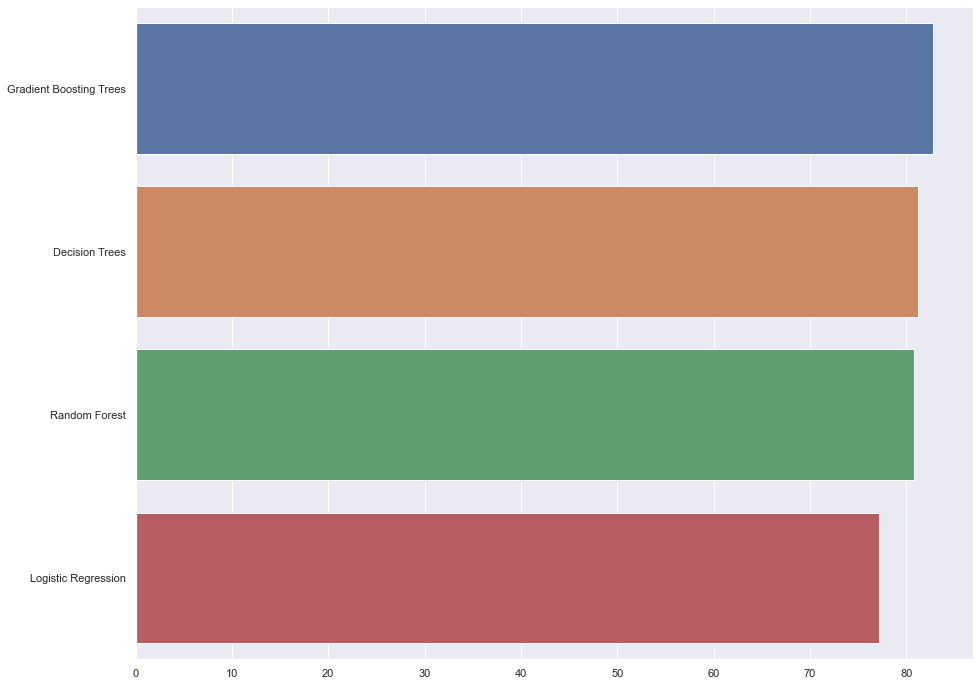

In [74]:
sns.set(rc = {'figure.figsize':(15, 12)})

model_classifiers = ['Gradient Boosting Trees', 'Decision Trees', 'Random Forest', 'Logistic Regression']

model_accuracies = [GBT_Accuracy * 100, DT_Accuracy * 100, RF_Accuracy * 100, LogReg_Accuracy * 100]

sns.barplot(y = model_classifiers, x = model_accuracies)

# Step 09: Calculate the confusion matrix and find the precision, recall, and F1 score of each classification algorithm. Explain how the accuracy of the predication can be improved? 

## GBT Model Performance

For this task, we must make a **Confusion Matrix**, find the **Precision, Recall and F1-Score** for all the algorithms.

We will be making use of built-in functions such as `MulticlassMetrics()`, `confusionMatrix()` for this task. For the other metrics like Precision, Recall and F1-Score, we can calculate them by **manipulating the confusion matrix**.

As we will repeat the same for everything, there's no need to repeat the documentation for everything.

In [75]:
GBT_Prediction_Labels = GBT_Prediction.select(['prediction', 'RainTomorrow_index'])

GBT_KPI = MulticlassMetrics(GBT_Prediction_Labels.rdd.map(list))

C:\Users\amank\Documents\spark\spark-3.4.0-bin-hadoop3\python\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [76]:
GBT_confusion_matrix = GBT_KPI.confusionMatrix().toArray()

print('GBT Confusion Matrix')

print(GBT_confusion_matrix)

GBT Confusion Matrix
[[31374.  1727.]
 [ 5128.  4681.]]


In [77]:
GBT_precision = (GBT_confusion_matrix[0][0]) / (GBT_confusion_matrix[0][0] + GBT_confusion_matrix[1][0])
print('GBT Precision = ' + str(GBT_precision))

GBT Precision = 0.8595145471481015


In [78]:
GBT_recall = (GBT_confusion_matrix[0][0]) / (GBT_confusion_matrix[0][0] + GBT_confusion_matrix[0][1])
print('GBT Recall = ' + str(GBT_recall))

GBT Recall = 0.9478263496571101


In [79]:
GBT_f1Score = (GBT_precision * GBT_recall) / (GBT_precision + GBT_recall) * 2
print('GBT F1 Score = ' + str(GBT_f1Score))

GBT F1 Score = 0.901512865824749


## Decision Trees Model Performance

In [80]:
DT_Prediction_Labels = DT_Prediction.select(['prediction', 'RainTomorrow_index'])

DT_KPI = MulticlassMetrics(DT_Prediction_Labels.rdd.map(list))

In [81]:
DT_confusion_matrix = DT_KPI.confusionMatrix().toArray()

print('DT Confusion Matrix')

print(DT_confusion_matrix)

DT Confusion Matrix
[[31664.  1437.]
 [ 5801.  4008.]]


In [82]:
DT_precision = (DT_confusion_matrix[0][0]) / (DT_confusion_matrix[0][0] + DT_confusion_matrix[1][0])
print('DT Precision = ' + str(DT_precision))

DT Precision = 0.8451621513412518


In [83]:
DT_recall = (DT_confusion_matrix[0][0]) / (DT_confusion_matrix[0][0] + DT_confusion_matrix[0][1])
print('DT Recall = ' + str(DT_recall))

DT Recall = 0.9565874142775143


In [84]:
DT_f1Score = (DT_precision * DT_recall) / (DT_precision + DT_recall) * 2
print('DT F1 Score = ' + str(DT_f1Score))

DT F1 Score = 0.8974293569140945


## Random Forest Model Performance

In [85]:
RF_Prediction_Labels = RF_Prediction.select(['prediction', 'RainTomorrow_index'])

RF_KPI = MulticlassMetrics(RF_Prediction_Labels.rdd.map(list))

In [86]:
RF_confusion_matrix = RF_KPI.confusionMatrix().toArray()

print('RF Confusion Matrix')

print(RF_confusion_matrix)

RF Confusion Matrix
[[32011.  1090.]
 [ 6143.  3666.]]


In [87]:
RF_precision = (RF_confusion_matrix[0][0]) / (RF_confusion_matrix[0][0] + RF_confusion_matrix[1][0])
print('RF Precision = ' + str(RF_precision))

RF Precision = 0.8389946008282224


In [88]:
RF_recall = (RF_confusion_matrix[0][0]) / (RF_confusion_matrix[0][0] + RF_confusion_matrix[0][1])
print('RF Recall = ' + str(RF_recall))

RF Recall = 0.9670704812543428


In [89]:
RF_f1Score = (RF_precision * RF_recall) / (RF_precision + RF_recall) * 2
print('RF F1 Score = ' + str(RF_f1Score))

RF F1 Score = 0.8984913339414777


## Logistic Regression Model Performance

In [90]:
LogReg_Prediction_Labels = LogReg_Prediction.select(['prediction', 'RainTomorrow_index'])

LogReg_KPI = MulticlassMetrics(LogReg_Prediction_Labels.rdd.map(list))

In [91]:
LogReg_confusion_matrix = LogReg_KPI.confusionMatrix().toArray()

print('LogReg Confusion Matrix')

print(LogReg_confusion_matrix)

LogReg Confusion Matrix
[[33101.     0.]
 [ 9809.     0.]]


In [92]:
LogReg_precision = (LogReg_confusion_matrix[0][0]) / (LogReg_confusion_matrix[0][0] + LogReg_confusion_matrix[1][0])
print('LogReg Precision = ' + str(LogReg_precision))

LogReg Precision = 0.771405266837567


In [93]:
LogReg_recall = (LogReg_confusion_matrix[0][0]) / (LogReg_confusion_matrix[0][0] + LogReg_confusion_matrix[0][1])
print('LogReg Recall = ' + str(LogReg_recall))

LogReg Recall = 1.0


In [94]:
LogReg_f1Score = (LogReg_precision * LogReg_recall) / (LogReg_precision + LogReg_recall) * 2
print('LogReg F1 Score = ' + str(LogReg_f1Score))

LogReg F1 Score = 0.8709528883977319


## How can we Improve the Accuracy?

We know that there isn't a single Machine Learning Algorithm that makes the best prediction on all problems. For example, SVM (Support Vector Machine) might do an okay job at **Regression** problems, but it does amazingly well at **Text Classification** problems. This is known as the **No Free Lunch** theorem. Therefore, we can only do trial and error with different algorithms unti we encounter the best algorithm for the problem.

There are two other ways which come to mind when we think about increasing the accuracy of the model :

1) **Hyperparameter Tuning** - This refers to finding the best set of parameters for any given problem, by tweeking and changing it and observing accuracy against it. We can automate this by using **grid search**, which basically makes use of a wide range of parameters for tweeking until the best set of parameters is found!

2) **Tackling Highly Imbalanced Data** - In this problem of predicting the RainTomorrow label, the initial proportion of Yes:No in the training set is about 1:4 which is highly imbalanced as the **Yes** class label is far less represented than the class **No** label. This can influence the prediction probability in our final model. This can be dealt with methods like **Prior Probability, Weighted Matrix** methods etc. 

# References

StringIndexer - https://stackoverflow.com/questions/36942233/apply-stringindexer-to-several-columns-in-a-pyspark-dataframe

VectorAssembler - https://stackoverflow.com/questions/32606294/create-feature-vector-programmatically-in-spark-ml-pyspark

Spark ML Guide - https://spark.apache.org/docs/latest/api/python/index.html

Seaborn - https://seaborn.pydata.org/